In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from astropy.time import Time, TimeDelta
import astropy.constants

c = astropy.constants.c.value

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [3]:
def load_file(path):
    ncols = 19
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

The file below is obtained by running the `dslwp_sme.script` GMAT script.

In [4]:
data = load_file('/home/daniel/jupyter_notebooks/dslwp/SME.txt')
t = Time(mjd2unixtimestamp(data[:,0]), format='unix')
sel = (Time('2018-10-07T09:50:00') <= t) & (t <= Time('2018-10-07T12:10:00'))
t = t[sel]
data = data[sel,:]

In [5]:
def rangerate(x):
    return np.sum(x[:,:3] * x[:,3:], axis=1) / np.sqrt(np.sum(x[:,:3]**2, axis=1)) * 1e3

def rangerate2doppler(x, freq = 436.4e6):
    return -x * freq / c

In [6]:
direct_doppler = rangerate2doppler(rangerate(data[:,1:7]))
direct_doppler_435 = rangerate2doppler(rangerate(data[:,1:7]), freq = 435.4e6)
direct_t = t

To compute the Moonbounce Doppler, we first compute the length of the reflection path by laying a fine grid of points on the Moon surface and choosing as reflection point the grid point that minimizes the sum of distances between the point and the satellite and Groundstation. The Doppler is computed as the time derivative of the length of the reflection path.

In [7]:
long, lat = np.meshgrid(np.linspace(-np.pi, np.pi, 1000), np.linspace(-np.pi/2, np.pi/2, 1000))
moon_radius = 1737
moon_x = moon_radius * np.cos(long) * np.cos(lat)
moon_y = moon_radius * np.sin(long) * np.cos(lat)
moon_z = moon_radius * np.sin(lat)
min_dist = np.empty(t.size)
for j in range(t.size):
    dist = np.sqrt((data[j,7]+moon_x)**2 + (data[j,8]+moon_y)**2 + (data[j,9]+moon_z)**2) + np.sqrt((data[j,7]+moon_x-data[j,1])**2 + (data[j,8]+moon_y-data[j,2])**2 + (data[j,9]+moon_z-data[j,3])**2) 
    min_dist[j] = np.min(dist)

In [8]:
moonbounce_rangerate = np.diff(min_dist)/np.diff(mjd2unixtimestamp(data[:,0])) * 1e3
moonbounce_doppler = rangerate2doppler(moonbounce_rangerate)
moonbounce_doppler_435 = rangerate2doppler(moonbounce_rangerate, 435.4e6)
moonbounce_t = Time(mjd2unixtimestamp((data[:-1,0] + data[1:,0])/2), format='unix')

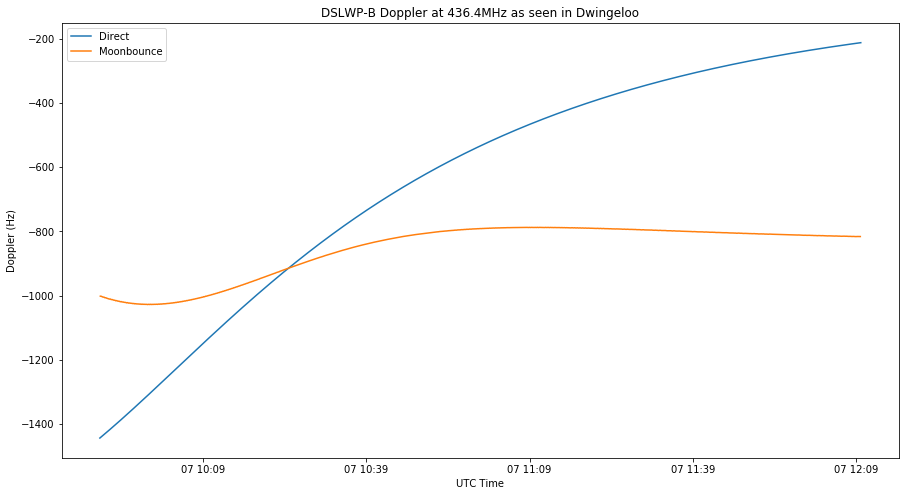

In [9]:
plt.figure(figsize = [15,8], facecolor='w')
plt.plot(direct_t.datetime, direct_doppler)
plt.plot(moonbounce_t.datetime, moonbounce_doppler)
plt.title('DSLWP-B Doppler at 436.4MHz as seen in Dwingeloo')
plt.xlabel('UTC Time')
plt.ylabel('Doppler (Hz)')
plt.legend(['Direct', 'Moonbounce']);

In [10]:
def waterfall_plot(image_path, start_time, timespan, doppler_offset = 750, band435 = False):
    img = mpimg.imread(image_path)
    img_start = Time(start_time)
    img_end = img_start + TimeDelta(timespan, format='sec')
    plt.figure(figsize = [15,8], facecolor='w')
    plt.plot(direct_t.datetime, direct_doppler if not band435 else direct_doppler_435)
    plt.plot(moonbounce_t.datetime, moonbounce_doppler if not band435 else moonbounce_doppler_435)
    if band435:
        for offset in 1000 + 312.5*np.arange(4):
            plt.plot(direct_t.datetime, direct_doppler + offset, color='C0', linewidth=1, linestyle=':')
            plt.plot(moonbounce_t.datetime, moonbounce_doppler + offset, color='C1', linewidth=1, linestyle=':')
    freq = '436.4MHz' if not band435 else '435.4MHz'
    plt.title(f'DSLWP-B Doppler at {freq} and signal recorded in Dwingeloo (offset {-doppler_offset}Hz)')
    plt.xlabel('UTC Time')
    plt.ylabel('Doppler (Hz)')
    plt.legend(['Direct', 'Moonbounce'])

    min_freq = -1000 if not band435 else 900-1800
    max_freq = 1000 if not band435 else 900+1800
    plt.imshow(img, extent = (mdates.date2num(img_start.datetime), mdates.date2num(img_end.datetime), min_freq-doppler_offset, max_freq-doppler_offset),\
               aspect = 'auto');

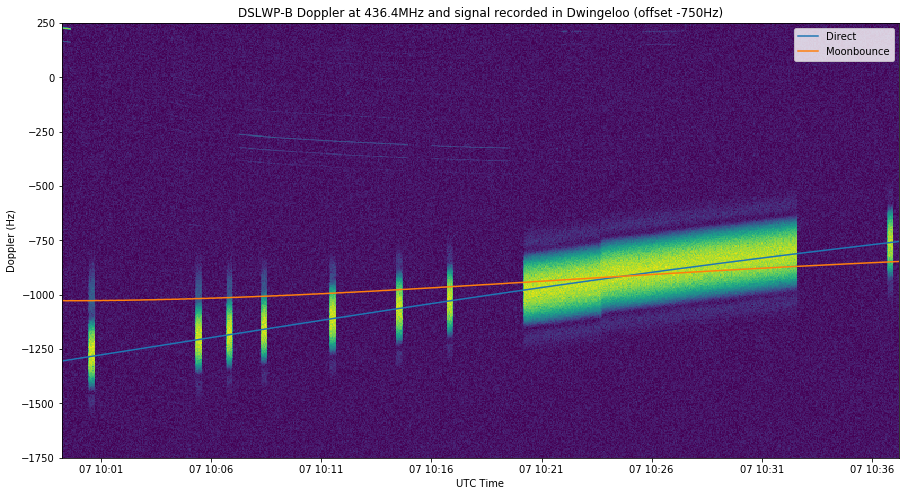

In [11]:
waterfall_plot('dslwp_sme0.png', '2018-10-07T09:59:13', 2280.8313)

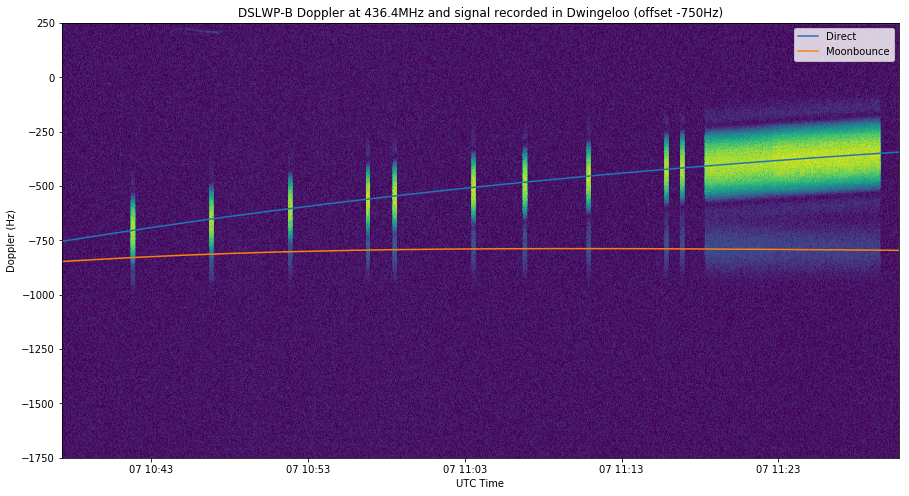

In [12]:
waterfall_plot('dslwp_sme1.png', '2018-10-07T10:37:18', 3203.4544)

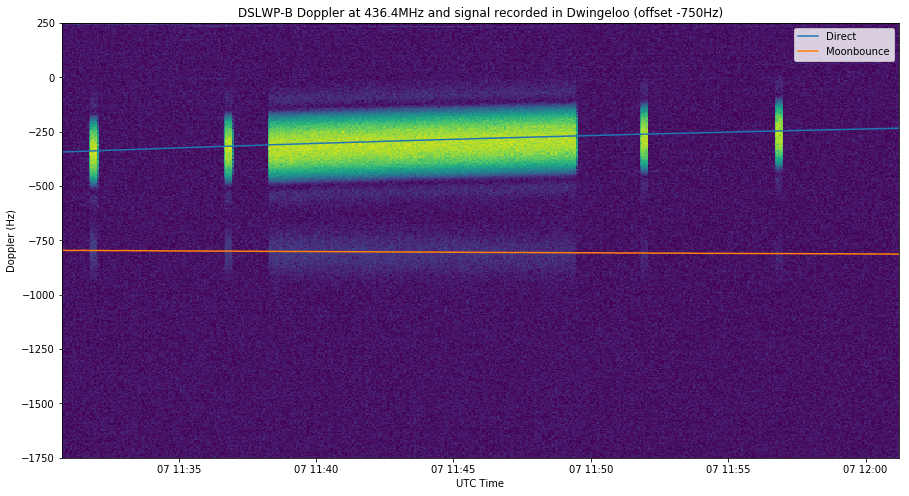

In [13]:
waterfall_plot('dslwp_sme2.png', '2018-10-07T11:30:45', 1827.902125)

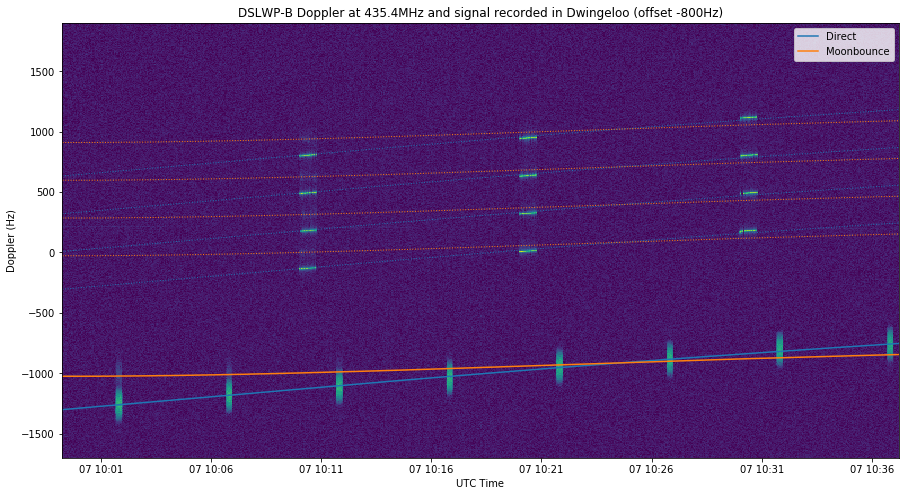

In [14]:
waterfall_plot('dslwp_sme0_435.png', '2018-10-07T09:59:13', 2280.8313, doppler_offset = 800, band435 = True)

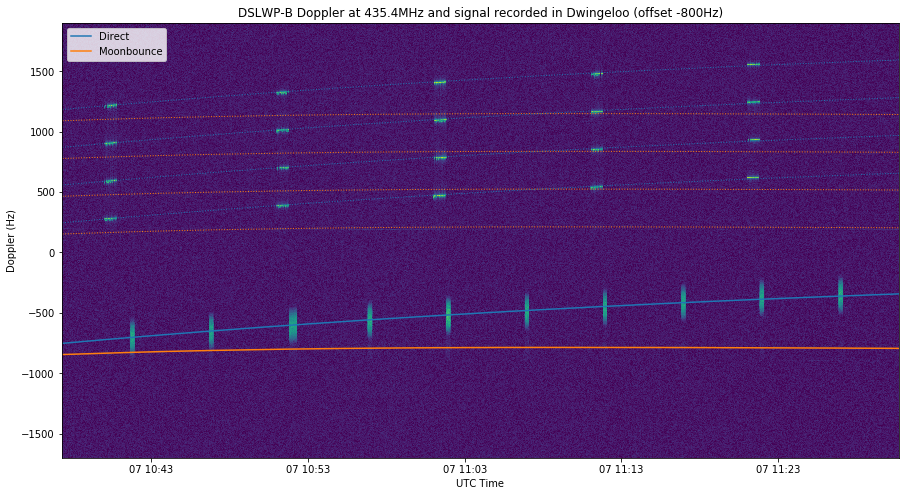

In [15]:
waterfall_plot('dslwp_sme1_435.png', '2018-10-07T10:37:18', 3203.4544, doppler_offset = 800, band435 = True)

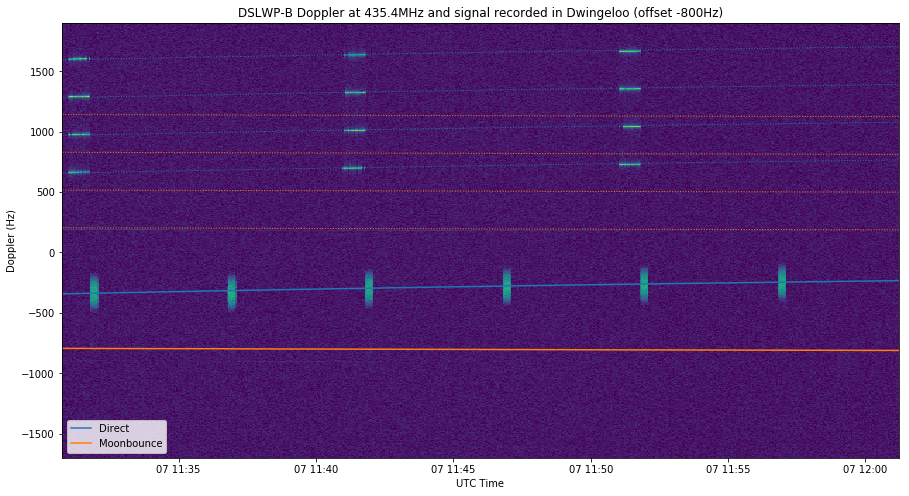

In [16]:
waterfall_plot('dslwp_sme2_435.png', '2018-10-07T11:30:45', 1827.902125, doppler_offset = 800, band435 = True)